In [ ]:
!pip install catboost

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px

from scipy.stats import moment, skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from joblib import dump, load

Files from the dataset have data about the sensor in the first 3 lines, we will skip these lines.

In [ ]:
def skip_fun(x):
    return x in (0, 1, 2)

# Classification of types of punches

## A first look at the data and its analysis

---



Let's download a separate file, and look at the data, conduct an initial analysis.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Boxing_class/train_file/train_d1/1 (2).txt", skiprows=skip_fun)

In [ ]:
data.rename(columns={"Time (s)": "Time",
                     " X (m/s2)": "X",
                     " Y (m/s2)": "Y",
                     " Z (m/s2)": "Z",
                     " R (m/s2)": "R",
                     " Theta (deg)": "Theta",
                     " Phi (deg)": "Phi",}, inplace=True)

In [ ]:
data["frec"] = 1 / data["Time"].diff()

In [ ]:
trace0 = go.Scatter(x=data["Time"], y=data["frec"], name="frec")
trace1 = go.Scatter(x=data["Time"], y=data["X"], name="acc_X")
trace2 = go.Scatter(x=data["Time"], y=data["Y"], name="acc_Y")
trace3 = go.Scatter(x=data["Time"], y=data["Z"], name="acc_Z")
trace4 = go.Scatter(x=data["Time"], y=data["R"], name="acc_full")
trace5 = go.Scatter(x=data["Time"], y=data["Theta"], name="Theta")
trace6 = go.Scatter(x=data["Time"], y=data["Phi"], name="Phi")


data_plot = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()
# plotly.offline.plot(fig, filename="fit_full_graph_1.html", show_link=False);

## See how to process the data, and look for the processing parameters for each sensor


Сreate a complete data set from all files in the directory.

In [ ]:
data_train = pd.DataFrame()
i = 0
train_path = "/content/drive/MyDrive/Boxing_class/test_file/test_d1/"
for file_name in os.listdir(train_path):
    data_i = pd.read_csv(train_path + file_name, skiprows=skip_fun)
    data_i["file_ind"] = i
    data_train = pd.concat([data_train, data_i], ignore_index=True)
    i += 1
data_train.rename(columns={"Time (s)": "Time",
                     " X (m/s2)": "X",
                     " Y (m/s2)": "Y",
                     " Z (m/s2)": "Z",
                     " R (m/s2)": "R",
                     " Theta (deg)": "Theta",
                     " Phi (deg)": "Phi",}, inplace=True)

data_train.sort_values(by=["file_ind", "Time"], inplace=True)

In [ ]:
data_train

In [ ]:
trace1 = go.Scatter(x=data_train.index, y=data_train["X"], name="acc_X")
trace2 = go.Scatter(x=data_train.index, y=data_train["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_train.index, y=data_train["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_train.index, y=data_train["R"], name="acc_full")
trace5 = go.Scatter(x=data_train.index, y=data_train["Theta"], name="Theta")
trace6 = go.Scatter(x=data_train.index, y=data_train["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()
# plotly.offline.plot(fig, filename="fit_full_graph_1.html", show_link=False);

In [ ]:
fig = px.scatter(x=data_train.index,
                 y=data_train["R"],
                 color=data_train["file_ind"])\
    .update_layout(title="Залежність повного прискорення від часу (color: file_ind)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')
fig.show()

We smooth our data using a median filter with a window of 4-6.

In [ ]:
data_train_filt = data_train.copy()

for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
    data_train_filt[i] = data_train_filt[[i]].rolling(5).mean()
    data_train_filt.loc[range(4), [i]] = data_train.loc[range(4), [i]]

In [ ]:
trace1 = go.Scatter(x=data_train_filt.index, y=data_train_filt["X"], name="acc_X")
trace2 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_train_filt.index, y=data_train_filt["R"], name="acc_full")
trace5 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Theta"], name="Theta")
trace6 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу (filt)",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()
# plotly.offline.plot(fig, filename="fit_full_graph_1.html", show_link=False);

Let's break down the signal into zones of rest and activity.

In [ ]:
data_train_filt["win_ind"] = data_train_filt.index // 100

data_win = data_train_filt.loc[:, ["R", "win_ind"]]\
    .groupby("win_ind")\
    .aggregate(lambda x: int((x.max() > 12) or (x.min() < 7)))\
    .rename(columns={"R": "Active"})\
    .reset_index()

data_train_filt = pd.merge(data_train_filt, data_win, how='outer', on='win_ind')

In [ ]:
fig = px.scatter(x=data_train_filt.index,
                 y=data_train_filt["R"],
                 color=data_train_filt["Active"])\
    .update_layout(title="Залежність повного прискорення від часу (filt, color: Active)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

## Data processing and markup

We perform all of the above for each part of the data set (directory)

In [ ]:
# A function that processes all files from a folder
# until the markup.
# The parameters (wind_size, action_max, action_min) for each folder
# were selected in the last paragraph.
def raw_data_to_ready_markup_data(data_path, wind_size, action_max, action_min):
  data_train = pd.DataFrame()
  i = 0
  dir = os.listdir(data_path)
  dir.sort()
  for file_name in dir:
      data_i = pd.read_csv(data_path + file_name, skiprows=skip_fun)
      data_i["file_ind"] = i
      data_train = pd.concat([data_train, data_i], ignore_index=True)
      i += 1
  data_train.rename(columns={"Time (s)": "Time",
                      " X (m/s2)": "X",
                      " Y (m/s2)": "Y",
                      " Z (m/s2)": "Z",
                      " R (m/s2)": "R",
                      " Theta (deg)": "Theta",
                      " Phi (deg)": "Phi",}, inplace=True)

  data_train.sort_values(by=["file_ind", "Time"], inplace=True)

  data_train_filt = data_train.copy()

  for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
      data_train_filt[i] = data_train_filt[[i]].rolling(5).mean()
      data_train_filt.loc[range(4), [i]] = data_train.loc[range(4), [i]]
  
  data_train_filt["win_ind"] = data_train_filt.index // wind_size

  data_win = data_train_filt.loc[:, ["R", "win_ind"]]\
      .groupby("win_ind")\
      .aggregate(lambda x: int((x.max() > action_max) or (x.min() < action_min)))\
      .rename(columns={"R": "Active"})\
      .reset_index()

  data_train_filt = pd.merge(data_train_filt, data_win, how='outer', on='win_ind')

  data_train_filt["action_index"] = 0
  action_ind = 0
  for i in range(1, data_train_filt.shape[0]):
      if data_train_filt.loc[i, "Active"] != data_train_filt.loc[i - 1, "Active"]:
          action_ind += 1
      data_train_filt.loc[i, "action_index"] = action_ind
  
  return(data_train_filt)

In [ ]:
data_train_M = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_M/",
                                             100, 13.5, 7)
data_train_B = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_B/",
                                             50, 13, 7)
data_train_D1 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_d1/",
                                             100, 12, 7)

In [ ]:
data_test_B = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_B/",
                                             125, 14, 7)
data_test_M = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_M/",
                                             125, 12, 7)
data_test_D1 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_d1/",
                                             100, 12, 7)
data_test_D2 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_d2/",
                                             25, 13.5, 6.5)

In [ ]:
data_test_D1 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_d1/",
                                             100, 12, 7)

In [ ]:
fig = px.scatter(x=data_test_D1.index,
                 y=data_test_D1["R"],
                 color=data_test_D1["action_index"])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

Let's mark the data: 0 - calm and artifacts, 1 - jab, 2 - uppercut, 3 - hook.

In [ ]:
fig = px.scatter(x=data_train_M.index,
                 y=data_train_M["R"],
                 color=data_train_M["file_ind"])\
    .update_layout(title="Залежність повного прискорення від часу (color: file_ind)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')
fig.show()

In [ ]:
fig = px.scatter(x=data_train_M[data_train_M["file_ind"] == 24].index,
                 y=data_train_M["R"][data_train_M["file_ind"] == 24],
                 color=data_train_M["action_index"][data_train_M["file_ind"] == 24])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

Here I separately looked at each file and marked up the data.

In [ ]:
[719, 721, 723, 725, 727, 751, 753, 755, 757, 759, 789, 793, 795, 797, 799, 801, 803, 805, 807]
[729, 731, 733, 735, 737, 761, 765, 767, 771, 773, ]
[739, 741, 743, 745, 747, 775, 777, 781, 783, 785, ]

[15, 21, 31, 35]

In [ ]:
x = [x for x in range(789, 808, 2)]
print(*x, sep = ", ")

789, 791, 793, 795, 797, 799, 801, 803, 805, 807


In [ ]:
data_train_M["real_action"] = 0

jab_ind = [1, 5, 7, 9, 11, 31, 33, 35, 37, 39, 61, 63, 65, 67, 69,
           93, 95, 97, 99, 103, 131, 133, 135, 137, 139, 161, 163, 165, 167, 169,
           191, 193, 195, 197, 199, 223, 225, 227, 229, 231, 253, 255, 257, 259, 261,
           283, 285, 287, 289, 291, 313, 315, 317, 319, 321, 345, 347, 349, 351, 353,
           377, 381, 383, 385, 387, 389, 415, 417, 419, 421, 423, 425, 447, 449, 451, 453, 455,
           481, 483, 485, 487, 489, 513, 515, 517, 519, 521, 549, 551, 553, 555, 557, 559,
           589, 615, 617, 619, 621, 623, 647, 649, 651, 653, 655, 683, 689,
           719, 721, 723, 725, 727, 751, 753, 755, 757, 759, 789, 793, 795, 797, 799, 801, 803, 805, 807]

uppercut_ind = [13, 15, 17, 19, 41, 43, 45, 47, 49, 71, 73, 75, 77, 79,
                107, 111, 113, 115, 117, 141, 143, 145, 147, 149, 171, 173, 175, 177, 179,
                201, 203, 205, 207, 209, 233, 235, 237, 239, 241, 263, 265, 267, 269, 271,
                293, 295, 297, 299, 301, 323, 325, 327, 329, 331, 355, 357, 359, 361, 363,
                391, 393, 395, 397, 399, 427, 429, 431, 433, 457, 459, 461, 465, 467,
                491, 493, 495, 497, 499, 523, 525, 527, 529, 531, 561, 563, 571,
                593, 595, 597, 599, 601, 625, 627, 629, 631, 633, 657, 659, 661, 663, 665,
                693, 695, 697, 699, 701, 703, 729, 731, 733, 735, 737, 761, 765, 767, 771, 773]
                
hook_ind = [21, 23, 25, 27, 29, 51, 53, 55, 57, 59, 81, 83, 85, 87, 89, 91,
            119, 121, 123, 125, 127, 151, 153, 155, 157, 159, 181, 183, 185, 187, 189,
            211, 213, 215, 217, 219, 221, 243, 245, 247, 249, 251, 273, 275, 277, 279, 281,
            303, 305, 307, 309, 311, 333, 335, 339, 341, 343, 365, 367, 369, 371, 373,
            401, 403, 407, 409, 435, 437, 439, 441, 443, 469, 471, 473, 475, 477,
            501, 503, 505, 507, 509, 535, 537, 539, 541, 543, 545, 579, 581, 583,
            603, 605, 607, 609, 611, 635, 639, 641, 667, 669, 671, 673, 675, 677,
            705, 707, 709, 711, 713, 739, 741, 743, 745, 747, 775, 777, 781, 783, 785]

data_train_M.loc[data_train_M["action_index"].isin(jab_ind), "real_action"] = 1
data_train_M.loc[data_train_M["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_M.loc[data_train_M["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
file_i = 24
fig = px.scatter(x=data_train_M[data_train_M["file_ind"] == file_i].index,
                 y=data_train_M["R"][data_train_M["file_ind"] == file_i],
                 color=data_train_M["real_action"][data_train_M["file_ind"] == file_i])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test_D1.index,
                 y=data_test_D1["R"],
                 color=data_test_D1["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
data_train_B["real_action"] = 0

jab_ind = [0, 2, 4, 6, 8,
           144, 148, 152]

uppercut_ind = [10, 14, 18, 22, 26, 30, 34, 36, 40, 44,
                92, 96, 98, 102, 104, 106, 108,
                158, 162, 164, 166, 170, 174, 180, 182, 184, 188]
                
hook_ind = [48, 54, 58, 62, 68, 72, 74, 78, 82, 86,
            110, 114, 118, 122, 126, 128, 130, 134, 136, 140,
            192, 196, 202, 208, 212, 218, 222, 224, 228, 232]

data_train_B.loc[data_train_B["action_index"].isin(jab_ind), "real_action"] = 1
data_train_B.loc[data_train_B["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_B.loc[data_train_B["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
data_train_D1["real_action"] = 0

jab_ind = [2, 4, 6, 8, 10, 12, 14,
           56, 58, 60, 62, 64, 66, 68, 70]

uppercut_ind = [16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
                72, 74, 76, 78, 80, 82, 84, 86, 88, 90]

hook_ind = [36, 38, 40, 42, 44, 46, 48, 50, 52, 54,
            92, 94, 96, 98, 100, 102, 104, 106, 108, 110]

data_train_D1.loc[data_train_D1["action_index"].isin(jab_ind), "real_action"] = 1
data_train_D1.loc[data_train_D1["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_D1.loc[data_train_D1["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
data_test_B["real_action"] = 0

jab_ind = [1, 3, 13, 15]

uppercut_ind = [5, 7, 19, 21]

hook_ind = [9, 11, 23, 27]

data_test_B.loc[data_test_B["action_index"].isin(jab_ind), "real_action"] = 1
data_test_B.loc[data_test_B["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_B.loc[data_test_B["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
data_test_M["real_action"] = 0

jab_ind = [1, 3, 13, 15, 25, 27, 37, 39, 49, 51, 61, 63]

uppercut_ind = [5, 7, 17, 19, 29, 31, 41, 43, 53, 55, 65, 67]

hook_ind = [9, 11, 21, 23, 33, 35, 45, 47, 57, 59, 69, 71]

data_test_M.loc[data_test_M["action_index"].isin(jab_ind), "real_action"] = 1
data_test_M.loc[data_test_M["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_M.loc[data_test_M["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
data_test_D1["real_action"] = 0

jab_ind = [1, 3, 13, 15]

uppercut_ind = [5, 7, 17, 19]

hook_ind = [9, 11, 21, 23]

data_test_D1.loc[data_test_D1["action_index"].isin(jab_ind), "real_action"] = 1
data_test_D1.loc[data_test_D1["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_D1.loc[data_test_D1["action_index"].isin(hook_ind), "real_action"] = 3

In [ ]:
data_test_D2["real_action"] = 0

jab_ind = [9, 23, 25]

uppercut_ind = [11, 13, 27, 29]

hook_ind = [15, 21, 31, 35]

data_test_D2.loc[data_test_D2["action_index"].isin(jab_ind), "real_action"] = 1
data_test_D2.loc[data_test_D2["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_D2.loc[data_test_D2["action_index"].isin(hook_ind), "real_action"] = 3

## Combination of data set and calculation of features

Let's combine everything into one data set. 

We need to move the action indexes carefully. So that we can distinguish the files in the future.

In [ ]:
data_test_M["action_index"] += data_test_B.action_index.max() + 1
data_test_D1["action_index"] += data_test_M.action_index.max() + 1
data_test_D2["action_index"] += data_test_D1.action_index.max() + 1

In [ ]:
data_train_B["action_index"] += data_train_M.action_index.max() + 1
data_train_D1["action_index"] += data_train_B.action_index.max() + 1

In [ ]:
data_train_full = pd.concat([data_train_M, data_train_B, data_train_D1], ignore_index=True)
data_test_full = pd.concat([data_test_B, data_test_M, data_test_D1, data_test_D2], ignore_index=True)

In [ ]:
# Let's take only the punches
data_train_full = data_train_full[data_train_full["real_action"] != 0]
data_test_full = data_test_full[data_test_full["real_action"] != 0]

In [ ]:
# A function that counts the number of signal crossings of its average value
def n_cross(x):
    x_del = x - x.mean()
    return (np.diff(np.sign(x_del)) != 0).sum()

# A function that counts the number of points
# where the signal is greater than the maximum value of the sensor
def n_sensor_limit_max(x):
    return (x >= 77).sum()

# A function that counts the number of points
# where the signal is greater than the minimum value of the sensor
def n_sensor_limit_min(x):
    return (x <= -77).sum()

Calculation of features for training and test

Train

In [ ]:
# For each action, we will calculate the statistical features that will be used in the model
# The set of statistical features is slightly different for data from the gyroscope and accelerometer
# So we count them separately
data_feature_train_acc = data_train_full.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

# Remove transformation artifacts
data_feature_train_acc = data_feature_train_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_acc = data_feature_train_acc.apply(lambda x: x.astype(float))

In [ ]:
# Similarly for the gyroscope
data_feature_train_cor = data_train_full.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_train_cor = data_feature_train_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_cor = data_feature_train_cor.apply(lambda x: x.astype(float))

In [ ]:
# Merge dataset => We received a ready train dataset for the first model
data_feature_train_acc.reset_index(inplace=True)
data_feature_train_cor.reset_index(inplace=True)
X_train = pd.merge(data_feature_train_acc, data_feature_train_cor, on="action_index")
X_train.drop("action_index", axis=1, inplace=True)

In [ ]:
y_train = data_train_full.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action

Test

In [ ]:
# Similarly for the test dataset
data_feature_test_acc = data_test_full.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_acc = data_feature_test_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_acc = data_feature_test_acc.apply(lambda x: x.astype(float))

In [ ]:
data_feature_test_cor = data_test_full.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_cor = data_feature_test_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_cor = data_feature_test_cor.apply(lambda x: x.astype(float))

In [ ]:
data_feature_test_acc.reset_index(inplace=True)
data_feature_test_cor.reset_index(inplace=True)
X_test = pd.merge(data_feature_test_acc, data_feature_test_cor, on="action_index")
X_test.drop("action_index", axis=1, inplace=True)

y_test = data_test_full.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action

In [ ]:
X_train.shape, y_train.shape

((481, 86), (481,))

In [ ]:
X_test.shape, y_test.shape

((71, 86), (71,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



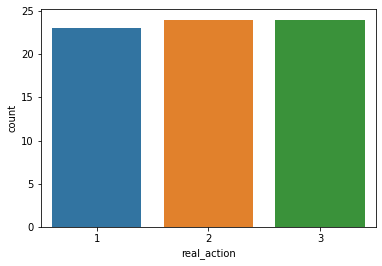

In [ ]:
sns.countplot(y_test);

## Model search

As my experience of working with similar data has shown, they showed themselves well:
1. KNeighborsClassifier
2. RandomForestClassifier
3. CatBoostClassifier

### CatBoost

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cat_score_train = []
cat_score_test = []

In [ ]:
for n_tree in [250, 275, 300, 325, 350, 400]:
    ctb = CatBoostClassifier(random_seed=17, iterations=n_tree, auto_class_weights="Balanced")
    cv_scores_train = []
    cv_scores_test = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        cv_train_df, cv_valid_df = (X_train.iloc[train_idx, :],
                                    X_train.iloc[test_idx, :])
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[test_idx]

        ctb.fit(cv_train_df, y_cv_train)

        cv_scores_train.append(roc_auc_score(y_cv_train, ctb.predict_proba(cv_train_df), multi_class="ovr"))
        cv_scores_test.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df), multi_class="ovr"))
    cat_score_train.append(np.mean(cv_scores_train))
    cat_score_test.append(np.mean(cv_scores_test))

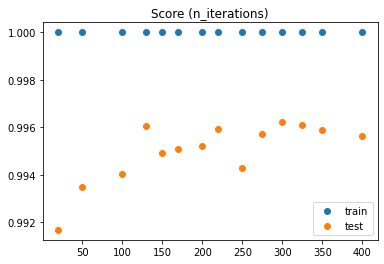

In [ ]:
plt.scatter([20, 50, 100, 130, 150, 170, 200, 220, 250, 275, 300, 325, 350, 400],
         cat_score_train, label="train")
plt.scatter([20, 50, 100, 130, 150, 170, 200, 220, 250, 275, 300, 325, 350, 400],
         cat_score_test, label="test")
plt.title("Score (n_iterations)")
plt.legend()
plt.show()

Ok, it stopped growing at about 350, since we will teach full train dataset, we will take 500 and it will be ok.

In [ ]:
ctb = CatBoostClassifier(random_seed=17, iterations=500, auto_class_weights="Balanced").fit(X_train, y_train)

In [ ]:
ctb_pred = ctb.predict_proba(X_test)
roc_auc_score(y_test, ctb_pred, multi_class="ovr")

0.9741558741905644

As we can see on the cross-validation during training, we squeezed out the maximum. The test is very good, see where the model went wrong and try others.


In [ ]:
confusion_matrix(y_test, ctb.predict(X_test))

array([[20,  1,  2],
       [ 1, 22,  1],
       [ 0,  2, 22]])

In [ ]:
pd.set_option('display.max_rows', 200)
ctb.predict(X_test)

Let's train the CatBoost for full data and save

In [ ]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

In [ ]:
ctb_full = CatBoostClassifier(random_seed=17, iterations=500, auto_class_weights="Balanced").fit(X, y)

In [ ]:
dump(ctb_full, "cat_model_full.joblib")
dump(ctb, "cat_model_train.joblib")

### RandomForest


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
rf_score_train = []
rf_score_test = []
for n_tree in [20, 50, 100, 150, 200, 300, 400, 500, 1000]:
    rf = RandomForestClassifier(random_state=17, n_estimators=n_tree,
                                class_weight="balanced", n_jobs=-1)
    cv_scores_train = []
    cv_scores_test = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        cv_train_df, cv_valid_df = (X_train.iloc[train_idx, :],
                                    X_train.iloc[test_idx, :])
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[test_idx]

        rf.fit(cv_train_df, y_cv_train)

        cv_scores_train.append(roc_auc_score(y_cv_train, rf.predict_proba(cv_train_df), multi_class="ovr"))
        cv_scores_test.append(roc_auc_score(y_cv_valid, rf.predict_proba(cv_valid_df), multi_class="ovr"))
    rf_score_train.append(np.mean(cv_scores_train))
    rf_score_test.append(np.mean(cv_scores_test))

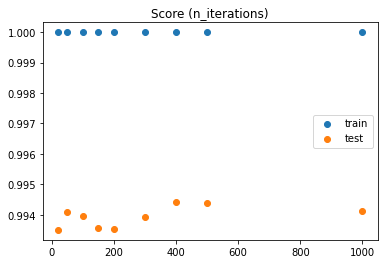

In [ ]:
plt.scatter([20, 50, 100, 150, 200, 300, 400, 500, 1000],
         rf_score_train, label="train")
plt.scatter([20, 50, 100, 150, 200, 300, 400, 500, 1000],
         rf_score_test, label="test")
plt.title("Score (n_iterations)")
plt.legend()
plt.show()

In [ ]:
rf = RandomForestClassifier(random_state=17, n_estimators=500,
                                class_weight="balanced", n_jobs=-1).fit(X_train, y_train)

In [ ]:
rf_pred = rf.predict_proba(X_test)
roc_auc_score(y_test, rf_pred, multi_class="ovr")

Forest works worse, but still save and try later.

In [ ]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

rf = RandomForestClassifier(random_state=17, n_estimators=500,
                                class_weight="balanced", n_jobs=-1).fit(X, y)

dump(rf, "rf_model_full.joblib")

### KNN

In [ ]:
Sts = StandardScaler()
X_train_St = Sts.fit_transform(X_train)
X_test_St = Sts.fit_transform(X_test)

Try without StandardScaler

In [ ]:
knn_score = []
for i in range(2, 20):
    knn = KNeighborsClassifier(n_neighbors= i, weights="distance").fit(X_train, y_train)
    knn_score.append(roc_auc_score(y_test, knn.predict_proba(X_test), multi_class="ovr"))

Try on scaled dataset

In [ ]:
knn_score = []
for i in range(2, 20):
    knn = KNeighborsClassifier(n_neighbors= i, weights="distance").fit(X_train_St, y_train)
    knn_score.append(roc_auc_score(y_test, knn.predict_proba(X_test_St), multi_class="ovr"))

Ok, it's a little worse again, but let it be, let's take a cat as the main model, but you can try knn later.

Teach models on full data and save them.

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 10, weights="distance").fit(X, y)

In [ ]:
dump(knn, "knn_model_full.joblib")

In [ ]:
Sts = StandardScaler()
X_St = Sts.fit_transform(X)

In [ ]:
knn = KNeighborsClassifier(n_neighbors= 10, weights="distance").fit(X_St, y)

In [ ]:
dump(Sts, "Sts_knn_model_full.joblib")

In [ ]:
dump(knn, "knn_model_full_St.joblib")

# Searching for punches during fight

Take a look at the fight data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Boxing_class/fight_file/09.txt", skiprows=skip_fun)
data.rename(columns={"Time (s)": "Time",
                     " X (m/s2)": "X",
                     " Y (m/s2)": "Y",
                     " Z (m/s2)": "Z",
                     " R (m/s2)": "R",
                     " Theta (deg)": "Theta",
                     " Phi (deg)": "Phi",}, inplace=True)

data["frec"] = 1 / data["Time"].diff()

In [ ]:
trace0 = go.Scatter(x=data["Time"], y=data["frec"], name="frec")
trace1 = go.Scatter(x=data["Time"], y=data["X"], name="acc_X")
trace2 = go.Scatter(x=data["Time"], y=data["Y"], name="acc_Y")
trace3 = go.Scatter(x=data["Time"], y=data["Z"], name="acc_Z")
trace4 = go.Scatter(x=data["Time"], y=data["R"], name="acc_full")
trace5 = go.Scatter(x=data["Time"], y=data["Theta"], name="Theta")
trace6 = go.Scatter(x=data["Time"], y=data["Phi"], name="Phi")


data_plot = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()

The first thing that catches your eye is the incredible noise in the data. 

Let's try to remove it.

## Select the filter for fight data

Ideas:
1. Median filter to cut out the impulse noises, and then smooth with an exponential filter
2. Median filter to cut out impulse noises and then smooth with a Kalman filter
3. Fourier filter to cut out jumps and hand tremors (Tried in another notebook, didn't work)

Try Median filter with 5- 50 window. 

In [ ]:
data_train_filt = data.copy()

for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
    data_train_filt[i] = data_train_filt[[i]].rolling(10).mean()
    data_train_filt.loc[range(9), [i]] = data.loc[range(9), [i]]

In [ ]:
trace1 = go.Scatter(x=data.index, y=data["X"], name="acc_X")
trace2 = go.Scatter(x=data.index, y=data["Y"], name="acc_Y")
trace3 = go.Scatter(x=data.index, y=data["Z"], name="acc_Z")
trace4 = go.Scatter(x=data.index, y=data["R"], name="acc_full")
trace5 = go.Scatter(x=data.index, y=data["Theta"], name="Theta")
trace6 = go.Scatter(x=data.index, y=data["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()

In [ ]:
trace1 = go.Scatter(x=data_train_filt.index, y=data_train_filt["X"], name="acc_X")
trace2 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_train_filt.index, y=data_train_filt["R"], name="acc_full")
trace5 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Theta"], name="Theta")
trace6 = go.Scatter(x=data_train_filt.index, y=data_train_filt["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу (filt)",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()

I think 10 will be enough for now.

Median + Exp filter

In [ ]:
def easy_mean(f, s_k=0.05, max_k=0.8, d=20):
    # Creating static variable
    if not hasattr(easy_mean, "fit"):
        easy_mean.fit = f

    # Adaptive ratio
    k = s_k if (abs(f - easy_mean.fit) < d) else max_k

    # Calculation easy mean
    easy_mean.fit += (f - easy_mean.fit) * k

    return easy_mean.fit

def normalise_exp(func):
    o = []
    for p in func:
        res = easy_mean(p)
        o.append(res)
    return o

In [ ]:
data_train_filt_2 = data_train_filt.copy()

for i in ["X", "Y", "Z", "R"]:
    data_train_filt_2[i] = normalise_exp(data_train_filt_2[i])

In [ ]:
trace1 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["X"], name="acc_X")
trace2 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["R"], name="acc_full")
trace5 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["Theta"], name="Theta")
trace6 = go.Scatter(x=data_train_filt_2.index, y=data_train_filt_2["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу (filt)",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()

Median + Kalman filter

In [ ]:
def kalman(f, q=0.5, r=7):
    if not hasattr(kalman, "Accumulated_Error"):
        kalman.Accumulated_Error = 1
        kalman.kalman_adc_old = 0

    if abs(f-kalman.kalman_adc_old)/50 > 0.25:
        Old_Input = f*0.382 + kalman.kalman_adc_old*0.618
    else:
        Old_Input = kalman.kalman_adc_old

    Old_Error_All = (kalman.Accumulated_Error**2 + q**2)**(1/2)
    H = Old_Error_All**2/(Old_Error_All**2 + r**2)
    kalman_adc = Old_Input + H * (f - Old_Input)
    kalman.Accumulated_Error = ((1 - H)*Old_Error_All**2)**(1/2)
    kalman.kalman_adc_old = kalman_adc

    return kalman_adc

def normalise_kl(func):
    o = []
    for p in func:
        res = kalman(p)
        o.append(res)
    return o

In [ ]:
data_train_filt_3 = data_train_filt.copy()

for i in ["X", "Y", "Z", "R"]:
    data_train_filt_3[i] = normalise_kl(data_train_filt_3[i])

In [ ]:
trace1 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["X"], name="acc_X")
trace2 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["R"], name="acc_full")
trace5 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["Theta"], name="Theta")
trace6 = go.Scatter(x=data_train_filt_3.index, y=data_train_filt_3["Phi"], name="Phi")


data_plot = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу (filt)",
          "xaxis_title" : "Час (номер точки)",
          "yaxis_title" : "Прискорення",
          "template" : "plotly"}

fig = go.Figure(data=data_plot, layout=layout)
fig.show()

## Data processing and markup for second model

We have filtered recordings of our 15 fights and our training for the first model, we will use all the data.

### The training data for the first model data

In [ ]:
def raw_data_to_ready_markup_data(data_path, wind_size, action_max, action_min):
  data_train = pd.DataFrame()
  i = 0
  dir = os.listdir(data_path)
  dir.sort()
  for file_name in dir:
      data_i = pd.read_csv(data_path + file_name, skiprows=skip_fun)
      data_i["file_ind"] = i
      data_train = pd.concat([data_train, data_i], ignore_index=True)
      i += 1
  data_train.rename(columns={"Time (s)": "Time",
                      " X (m/s2)": "X",
                      " Y (m/s2)": "Y",
                      " Z (m/s2)": "Z",
                      " R (m/s2)": "R",
                      " Theta (deg)": "Theta",
                      " Phi (deg)": "Phi",}, inplace=True)

  data_train.sort_values(by=["file_ind", "Time"], inplace=True)

  data_train_filt = data_train.copy()

  for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
      data_train_filt[i] = data_train_filt[[i]].rolling(5).mean()
      data_train_filt.loc[range(4), [i]] = data_train.loc[range(4), [i]]
  
  data_train_filt["win_ind"] = data_train_filt.index // wind_size

  data_win = data_train_filt.loc[:, ["R", "win_ind"]]\
      .groupby("win_ind")\
      .aggregate(lambda x: int((x.max() > action_max) or (x.min() < action_min)))\
      .rename(columns={"R": "Active"})\
      .reset_index()

  data_train_filt = pd.merge(data_train_filt, data_win, how='outer', on='win_ind')

  data_train_filt["action_index"] = 0
  action_ind = 0
  for i in range(1, data_train_filt.shape[0]):
      if data_train_filt.loc[i, "Active"] != data_train_filt.loc[i - 1, "Active"]:
          action_ind += 1
      data_train_filt.loc[i, "action_index"] = action_ind
  
  return(data_train_filt)

In [ ]:
data_train_M = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_M/",
                                             100, 13.5, 7)
data_train_B = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_B/",
                                             50, 13, 7)
data_train_D1 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/train_file/train_d1/",
                                             100, 12, 7)
data_test_B = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_B/",
                                             125, 14, 7)
data_test_M = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_M/",
                                             125, 12, 7)
data_test_D1 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_d1/",
                                             100, 12, 7)
data_test_D2 = raw_data_to_ready_markup_data("/content/drive/MyDrive/Boxing_class/test_file/test_d2/",
                                             25, 13.5, 6.5)

In [ ]:
data_train_M["real_action"] = 0

punch_ind = [1, 5, 7, 9, 11, 31, 33, 35, 37, 39, 61, 63, 65, 67, 69,
           93, 95, 97, 99, 103, 131, 133, 135, 137, 139, 161, 163, 165, 167, 169,
           191, 193, 195, 197, 199, 223, 225, 227, 229, 231, 253, 255, 257, 259, 261,
           283, 285, 287, 289, 291, 313, 315, 317, 319, 321, 345, 347, 349, 351, 353,
           377, 381, 383, 385, 387, 389, 415, 417, 419, 421, 423, 425, 447, 449, 451, 453, 455,
           481, 483, 485, 487, 489, 513, 515, 517, 519, 521, 549, 551, 553, 555, 557, 559,
           589, 615, 617, 619, 621, 623, 647, 649, 651, 653, 655, 683, 689,
           719, 721, 723, 725, 727, 751, 753, 755, 757, 759, 789, 793, 795, 797, 799, 801, 803, 805, 807,
           13, 15, 17, 19, 41, 43, 45, 47, 49, 71, 73, 75, 77, 79,
                107, 111, 113, 115, 117, 141, 143, 145, 147, 149, 171, 173, 175, 177, 179,
                201, 203, 205, 207, 209, 233, 235, 237, 239, 241, 263, 265, 267, 269, 271,
                293, 295, 297, 299, 301, 323, 325, 327, 329, 331, 355, 357, 359, 361, 363,
                391, 393, 395, 397, 399, 427, 429, 431, 433, 457, 459, 461, 465, 467,
                491, 493, 495, 497, 499, 523, 525, 527, 529, 531, 561, 563, 571,
                593, 595, 597, 599, 601, 625, 627, 629, 631, 633, 657, 659, 661, 663, 665,
                693, 695, 697, 699, 701, 703, 729, 731, 733, 735, 737, 761, 765, 767, 771, 773,
             21, 23, 25, 27, 29, 51, 53, 55, 57, 59, 81, 83, 85, 87, 89, 91,
            119, 121, 123, 125, 127, 151, 153, 155, 157, 159, 181, 183, 185, 187, 189,
            211, 213, 215, 217, 219, 221, 243, 245, 247, 249, 251, 273, 275, 277, 279, 281,
            303, 305, 307, 309, 311, 333, 335, 339, 341, 343, 365, 367, 369, 371, 373,
            401, 403, 407, 409, 435, 437, 439, 441, 443, 469, 471, 473, 475, 477,
            501, 503, 505, 507, 509, 535, 537, 539, 541, 543, 545, 579, 581, 583,
            603, 605, 607, 609, 611, 635, 639, 641, 667, 669, 671, 673, 675, 677,
            705, 707, 709, 711, 713, 739, 741, 743, 745, 747, 775, 777, 781, 783, 785]

data_train_M.loc[data_train_M["action_index"].isin(punch_ind), "real_action"] = 1

In [ ]:
data_train_B["real_action"] = 0

punch_ind = [0, 2, 4, 6, 8,
           144, 148, 152,
           10, 14, 18, 22, 26, 30, 34, 36, 40, 44,
                92, 96, 98, 102, 104, 106, 108,
                158, 162, 164, 166, 170, 174, 180, 182, 184, 188,
           48, 54, 58, 62, 68, 72, 74, 78, 82, 86,
            110, 114, 118, 122, 126, 128, 130, 134, 136, 140,
            192, 196, 202, 208, 212, 218, 222, 224, 228, 232]


data_train_B.loc[data_train_B["action_index"].isin(punch_ind), "real_action"] = 1

data_train_D1["real_action"] = 0

punch_ind = [2, 4, 6, 8, 10, 12, 14,
           56, 58, 60, 62, 64, 66, 68, 70,
           16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
                72, 74, 76, 78, 80, 82, 84, 86, 88, 90,
             36, 38, 40, 42, 44, 46, 48, 50, 52, 54,
            92, 94, 96, 98, 100, 102, 104, 106, 108, 110]

data_train_D1.loc[data_train_D1["action_index"].isin(punch_ind), "real_action"] = 1

In [ ]:
data_test_B["real_action"] = 0
jab_ind = [1, 3, 13, 15, 5, 7, 19, 21, 9, 11, 23, 27]
data_test_B.loc[data_test_B["action_index"].isin(jab_ind), "real_action"] = 1


data_test_D1["real_action"] = 0
jab_ind = [1, 3, 13, 15, 5, 7, 17, 19, 9, 11, 21, 23]
data_test_D1.loc[data_test_D1["action_index"].isin(jab_ind), "real_action"] = 1


data_test_D2["real_action"] = 0
jab_ind = [9, 23, 25, 11, 13, 27, 29, 15, 21, 31, 35]
data_test_D2.loc[data_test_D2["action_index"].isin(jab_ind), "real_action"] = 1

data_test_M["real_action"] = 0

jab_ind = [1, 3, 13, 15, 25, 27, 37, 39, 49, 51, 61, 63,
           5, 7, 17, 19, 29, 31, 41, 43, 53, 55, 65, 67,
           9, 11, 21, 23, 33, 35, 45, 47, 57, 59, 69, 71]
data_test_M.loc[data_test_M["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
fig = px.scatter(x=data_test_D2.index,
                 y=data_test_D2["R"],
                 color=data_test_D2["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test_D2.index,
                 y=data_test_D2["R"],
                 color=data_test_D2["action_index"])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
file_i = 24
fig = px.scatter(x=data_train_M[data_train_M["file_ind"] == file_i].index,
                 y=data_train_M["R"][data_train_M["file_ind"] == file_i],
                 color=data_train_M["action_index"][data_train_M["file_ind"] == file_i])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
file_i = 4
fig = px.scatter(x=data_train_M[data_train_M["file_ind"] == file_i].index,
                 y=data_train_M["R"][data_train_M["file_ind"] == file_i],
                 color=data_train_M["real_action"][data_train_M["file_ind"] == file_i])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

### Fight dataset

In [ ]:
def kalman(f, q=0.5, r=7):
    if not hasattr(kalman, "Accumulated_Error"):
        kalman.Accumulated_Error = 1
        kalman.kalman_adc_old = 0

    if abs(f-kalman.kalman_adc_old)/50 > 0.25:
        Old_Input = f*0.382 + kalman.kalman_adc_old*0.618
    else:
        Old_Input = kalman.kalman_adc_old

    Old_Error_All = (kalman.Accumulated_Error**2 + q**2)**(1/2)
    H = Old_Error_All**2/(Old_Error_All**2 + r**2)
    kalman_adc = Old_Input + H * (f - Old_Input)
    kalman.Accumulated_Error = ((1 - H)*Old_Error_All**2)**(1/2)
    kalman.kalman_adc_old = kalman_adc

    return kalman_adc

def normalise_kl(func):
    o = []
    for p in func:
        res = kalman(p)
        o.append(res)
    return o

In [ ]:
def raw_data_to_ready_markup_data_new(data_path, wind_size):
  data_train = pd.read_csv(data_path, skiprows=skip_fun)

  data_train.rename(columns={"Time (s)": "Time",
                      " X (m/s2)": "X",
                      " Y (m/s2)": "Y",
                      " Z (m/s2)": "Z",
                      " R (m/s2)": "R",
                      " Theta (deg)": "Theta",
                      " Phi (deg)": "Phi",}, inplace=True)


  data_train_filt = data_train.copy()

  for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
      data_train_filt[i] = data_train_filt[[i]].rolling(10).mean()
      data_train_filt.loc[range(9), [i]] = data_train.loc[range(9), [i]]
  
  for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
      data_train_filt[i] = normalise_kl(data_train_filt[i])
  
  data_train_filt["action_index"] = data_train_filt.index // wind_size 
  return(data_train_filt)

In [ ]:
data_train01 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/01.txt", 120)
data_train02 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/02.txt", 120)
data_train03 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/03.txt", 120)
data_train04 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/04.txt", 120)
data_train05 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/05.txt", 120)
data_train06 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/06.txt", 120)
data_train07 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/07.txt", 120)
data_train10 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/10.txt", 120)
data_train11 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/11.txt", 120)
data_train12 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/12.txt", 120)
data_train13 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/13.txt", 120)
data_train14 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/14.txt", 120)
data_train15 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/15.txt", 120)

In [ ]:
data_train14 = raw_data_to_ready_markup_data_new("/content/drive/MyDrive/Boxing_class/fight_file/14.txt", 120)

In [ ]:
fig = px.scatter(x=data_train04["Time"],
                 y=data_train04["R"],
                 color=data_train04["action_index"])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
[4, 5, 6, 17, 18, 20, 21, 22, 23, 24, 30, 31, 32, 42, 43, 49, 50, 51, 57, 58, 61, 62, 63
 69, 70, 71, 72, 73, 74, 79, 80, 86, 87, 88, 99, 100, 105, 106, 107, 112, 113, 119, 128, 129, 135, 136]

[59, 60, 61, 93, 94, 95, 126, 127, 135, 136]

In [ ]:
for x in range(61, 68):
  print(x, end=", ")

61, 62, 63, 64, 65, 66, 67, 

In [ ]:
data_train15["real_action"] = 0

jab_ind = [4, 5, 6, 17, 18, 20, 21, 22, 23, 24, 30, 31, 32, 42, 43, 49, 50, 51, 57, 58, 61, 62, 63,
 69, 70, 71, 72, 73, 74, 79, 80, 86, 87, 88, 99, 100, 105, 106, 107, 112, 113, 119, 128, 129, 135, 136]

data_train15.loc[data_train15["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
fig = px.scatter(x=data_train04["Time"],
                 y=data_train04["R"],
                 color=data_train04["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
data_train01["real_action"] = 0

jab_ind = [4, 5, 6, 23, 24, 25, 37, 38, 39, 44, 45, 46, 47, 48, 58, 59, 60, 63, 64, 65,
 71, 72, 73, 78, 79, 80, 81, 82, 83, 86, 87, 88, 96, 97, 115, 116, 117, 134, 135, 147, 148]

uppercut_ind = [10, 11, 12, 26, 27, 28, 61, 62, 88, 89, 90, 102, 103, 118, 119, 120, 137, 138]
                
hook_ind = [14, 15, 16, 30, 31, 32, 55, 56, 57, 99, 100, 106, 107, 123, 124, 125, 139, 140, 141]

data_train01.loc[data_train01["action_index"].isin(jab_ind), "real_action"] = 1
data_train01.loc[data_train01["action_index"].isin(uppercut_ind), "real_action"] = 1
data_train01.loc[data_train01["action_index"].isin(hook_ind), "real_action"] = 1

In [ ]:
data_train02["real_action"] = 0

jab_ind = [3, 4, 5, 8, 9, 10, 11, 12, 13, 17, 18, 22, 23, 24, 25, 26, 30, 31, 32, 38, 39, 41,
 42, 45, 46, 49, 50, 51, 52, 55, 56, 61, 62, 63, 64, 65, 69, 70, 71, 72, 73, 78, 79, 80, 81, 82,
 86, 87, 92, 93, 96, 97, 98, 99, 100, 104, 105, 106, 107, 108, 109, 114, 115, 119, 120,
 125, 126, 129, 130, 136, 137, 142, 143, 144, 148, 149, 150]

data_train02.loc[data_train02["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train03["real_action"] = 0

jab_ind = [5, 6, 7, 12, 13, 14, 17, 18, 24, 25, 26, 30, 31, 33, 34, 35, 39, 40, 41, 43, 44,
 49, 50, 53, 54, 55, 56, 57, 58, 62, 63, 66, 67, 70, 71, 72, 74, 75, 81, 82, 83, 
 90, 91, 93, 94, 95, 96, 97, 98, 105, 106, 109, 110, 118, 119, 121, 122, 123, 126, 127, 128]

data_train03.loc[data_train03["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train04["real_action"] = 0

jab_ind = [6, 7, 8, 12, 13, 14, 18, 19, 24, 25, 29, 30, 31, 32, 35, 36, 38, 39, 40, 41, 45, 46, 47,
 52, 53, 58, 59, 60, 63, 64, 65, 68, 69, 70, 74, 75, 76, 80, 81,82, 83, 86, 87, 88, 89, 90, 94, 95,
 100, 101, 102, 107, 108, 109, 110, 111, 112, 117, 118, 119, 122, 123, 124, 127, 128, 129]

data_train04.loc[data_train04["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train05["real_action"] = 0

jab_ind = [4, 5, 6, 9, 10, 11, 14, 15, 16, 20, 21, 22, 27, 28, 29, 36, 37, 38, 39, 40,
 45, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 71, 72, 73,
 75, 76, 79, 80, 88, 89, 90, 95, 96, 98 ,99, 100, 104, 105, 106, 108, 109,110, 
 114, 115, 116,117, 118, 121, 122, 123, 129, 130, 135, 136, 138, 139, 140]

data_train05.loc[data_train05["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train06["real_action"] = 0

jab_ind = [4, 5, 6, 10, 11, 12, 16, 17, 21, 22, 25, 26, 32, 33, 34, 38, 39, 40, 44, 45, 46,
 51, 52, 53, 54, 55, 56, 57, 61, 62, 63, 64, 65,69, 70 ,72, 73, 79, 80, 81, 82, 
 85, 86, 87, 88, 91, 92,  96, 97, 98, 99, 100, 93, 103, 104, 105, 109, 110, 111,
 114, 115, 116, 119, 120, 125, 126, 129, 130, 131]

data_train06.loc[data_train06["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train07["real_action"] = 0

jab_ind = [7, 8, 14, 15,16, 19, 20, 21, 22, 23, 29, 30, 33, 34, 35, 36, 39 ,40, 41, 44, 45, 46, 47,
 53, 54, 55, 56, 57, 63, 64, 65, 67, 68, 69, 71, 72]

data_train07.loc[data_train07["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train10["real_action"] = 0

jab_ind = [11, 12, 13, 19, 20, 21, 27, 28, 29, 34, 35,36, 41, 42, 44, 45, 46, 54, 55, 56,
 60, 61, 69, 70, 71, 72, 78, 79, 80, 83, 84, 85, 86, 87, 88, 98, 99, 103, 104, 105,
 110, 111, 113, 114, 115, 128, 129, 130, 134, 135, 136]

data_train10.loc[data_train10["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train11["real_action"] = 0

jab_ind = [3, 4, 5, 19, 20, 39, 40, 41, 76, 77, 78, 108, 109]

uppercut_ind = [12, 13, 26, 27, 63, 64, 89, 90, 120, 121, 135, 136]
                
hook_ind = [31, 32, 33, 46, 47, 99, 100, 127, 128, 129]

data_train11.loc[data_train11["action_index"].isin(jab_ind), "real_action"] = 1
data_train11.loc[data_train11["action_index"].isin(uppercut_ind), "real_action"] = 1
data_train11.loc[data_train11["action_index"].isin(hook_ind), "real_action"] = 1

In [ ]:
data_train12["real_action"] = 0

jab_ind = [9, 10, 11, 34, 35, 36, 55, 56, 57, 85, 86, 87, 102, 103, 104, 126, 127, 128, 133, 134, 70, 71, 72]

uppercut_ind = [20, 21, 44, 45, 67, 68, 114, 115]
                
hook_ind = [28, 29, 30]

data_train12.loc[data_train12["action_index"].isin(jab_ind), "real_action"] = 1
data_train12.loc[data_train12["action_index"].isin(uppercut_ind ), "real_action"] = 1
data_train12.loc[data_train12["action_index"].isin(hook_ind), "real_action"] = 1

In [ ]:
data_train13["real_action"] = 0

jab_ind = [8, 9, 10, 15, 16, 29, 30, 32, 33, 34, 38, 44, 45, 46, 53, 57, 58, 63, 64, 84, 85, 92, 93,
 98, 99, 100, 104, 105, 106,  112, 113, 125, 126,  131, 132, 133, 137, 138, 139]

data_train13.loc[data_train13["action_index"].isin(jab_ind), "real_action"] = 1

In [ ]:
data_train14["real_action"] = 0

jab_ind = [9, 10, 11, 22, 23, 24, 34, 35, 36, 77, 78, 79, 119, 120, 121]

uppercut_ind = [56, 57, 58, 82, 83, 84, 112, 113, 114, 123, 124, 138, 139, 140]
                
hook_ind = [47, 48, 49, 59, 60, 61, 93, 94, 95, 126, 127, 135, 136]

data_train14.loc[data_train14["action_index"].isin(jab_ind), "real_action"] = 1
data_train14.loc[data_train14["action_index"].isin(uppercut_ind ), "real_action"] = 1
data_train14.loc[data_train14["action_index"].isin(hook_ind), "real_action"] = 1

In [ ]:
data_train15["real_action"] = 0

jab_ind = [4, 5, 6, 17, 18, 20, 21, 22, 23, 24, 30, 31, 32, 42, 43, 49, 50, 51, 57, 58, 61, 62, 63,
 69, 70, 71, 72, 73, 74, 79, 80, 86, 87, 88, 99, 100, 105, 106, 107, 112, 113, 119, 128, 129, 135, 136]

data_train15.loc[data_train15["action_index"].isin(jab_ind), "real_action"] = 1

## Combination of data set and calculation of features for second model

We will create a training set

In [ ]:
data_test_M["action_index"] += data_test_B.action_index.max() + 1
data_test_D1["action_index"] += data_test_M.action_index.max() + 1
data_test_D2["action_index"] += data_test_D1.action_index.max() + 1

data_train_M["action_index"] += data_test_D2.action_index.max() + 1
data_train_B["action_index"] += data_train_M.action_index.max() + 1
data_train_D1["action_index"] += data_train_B.action_index.max() + 1

In [ ]:
data_old_full = pd.concat([data_test_B, data_test_M, data_test_D1, data_test_D2,
                           data_train_M, data_train_B, data_train_D1], ignore_index=True)
data_old_full.drop(["file_ind", "win_ind", "Active"], axis=1, inplace=True)

In [ ]:
data_train01["action_index"] += data_train_D1.action_index.max() + 1
data_train02["action_index"] += data_train01.action_index.max() + 1
data_train03["action_index"] += data_train02.action_index.max() + 1
data_train04["action_index"] += data_train03.action_index.max() + 1
data_train05["action_index"] += data_train04.action_index.max() + 1
data_train06["action_index"] += data_train05.action_index.max() + 1
data_train07["action_index"] += data_train06.action_index.max() + 1
data_train10["action_index"] += data_train07.action_index.max() + 1
data_train11["action_index"] += data_train10.action_index.max() + 1
data_train13["action_index"] += data_train11.action_index.max() + 1
data_train15["action_index"] += data_train13.action_index.max() + 1

In [ ]:
data_new_full = pd.concat([data_train01, data_train02, data_train03, data_train04,
                           data_train05, data_train06, data_train07, data_train10,
                           data_train11, data_train13, data_train15], ignore_index=True)

In [ ]:
data_train_full = pd.concat([data_old_full, data_new_full], ignore_index=True)

In [ ]:
data_train_full

In [ ]:
def n_cross(x):
    x_del = x - x.mean()
    return (np.diff(np.sign(x_del)) != 0).sum()


def n_sensor_limit_max(x):
    return (x >= 77).sum()


def n_sensor_limit_min(x):
    return (x <= -77).sum()

In [ ]:
data_feature_train_acc = data_train_full.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_train_acc = data_feature_train_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_acc = data_feature_train_acc.apply(lambda x: x.astype(float))

data_feature_train_cor = data_train_full.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_train_cor = data_feature_train_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_cor = data_feature_train_cor.apply(lambda x: x.astype(float))

In [ ]:
data_feature_train_acc.reset_index(inplace=True)
data_feature_train_cor.reset_index(inplace=True)
X_train = pd.merge(data_feature_train_acc, data_feature_train_cor, on="action_index")
X_train.drop("action_index", axis=1, inplace=True)

y_train = data_train_full.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action

Test

In [ ]:
data_test1 = data_test_D1.copy()
data_test2 = data_train01.copy()
data_test3 = data_train11.copy()
data_test4 = data_train12.copy()
data_test5 = data_train14.copy()

In [ ]:
data_test1["action_index"] = data_test1["action_index"] - 104
data_test2["action_index"] = data_test2["action_index"] - 1333
data_test3["action_index"] = data_test3["action_index"] - 2429

In [ ]:
def do_feature(data):
  data_feature_train_acc = data.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

  data_feature_train_acc = data_feature_train_acc.T.reset_index().T.drop(["level_0", "level_1"])
  data_feature_train_acc = data_feature_train_acc.apply(lambda x: x.astype(float))

  data_feature_train_cor = data.loc[:, ["Theta", "Phi", "action_index"]]\
      .groupby("action_index").aggregate([
      lambda x: x.mean(),
      lambda x: x.std(),
      lambda x: x.max(),
      lambda x: x.min(),
      lambda x: x.max() - x.min(),
      lambda x: np.percentile(x, 25),
      lambda x: np.percentile(x, 50),
      lambda x: np.percentile(x, 75),
      lambda x: skew(x),
      lambda x: kurtosis(x),
      lambda x: n_cross(x),
      lambda x: n_sensor_limit_max(x),
      lambda x: n_sensor_limit_min(x)])

  data_feature_train_cor = data_feature_train_cor.T.reset_index().T.drop(["level_0", "level_1"])
  data_feature_train_cor = data_feature_train_cor.apply(lambda x: x.astype(float))

  data_feature_train_acc.reset_index(inplace=True)
  data_feature_train_cor.reset_index(inplace=True)
  X_train = pd.merge(data_feature_train_acc, data_feature_train_cor, on="action_index")
  X_train.drop("action_index", axis=1, inplace=True)

  y_train = data.loc[:, ["real_action", "action_index"]]\
              .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action
  
  return(X_train, y_train)

In [ ]:
X_test1, y_test1 = do_feature(data_test1)
X_test2, y_test2 = do_feature(data_test2)
X_test3, y_test3 = do_feature(data_test3)
X_test4, y_test4 = do_feature(data_test4)
X_test5, y_test5 = do_feature(data_test5)

In [ ]:
X_test5.shape, y_test5.shape

((148, 86), (148,))

## Model search

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
roc_score_train = []
roc_score_test = []
prec_score_train = []
prec_score_test = []
rec_score_train = []
rec_score_test = []

In [ ]:
for n_tree in [20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000]:
    ctb = CatBoostClassifier(random_seed=17, iterations=n_tree, auto_class_weights="Balanced")

    cv_roc_scores_train, cv_roc_scores_test = [], []
    cv_rec_scores_train, cv_rec_scores_test = [], []
    cv_prec_scores_train, cv_prec_scores_test = [], []

    for train_idx, test_idx in skf.split(X_train, y_train):
        cv_train_df, cv_valid_df = (X_train.iloc[train_idx, :],
                                    X_train.iloc[test_idx, :])
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[test_idx]

        ctb.fit(cv_train_df, y_cv_train)

        cv_roc_scores_train.append(roc_auc_score(y_cv_train, ctb.predict_proba(cv_train_df)[:, 1]))
        cv_roc_scores_test.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df)[:, 1]))
        cv_rec_scores_train.append(recall_score(y_cv_train, ctb.predict(cv_train_df)))
        cv_rec_scores_test.append(recall_score(y_cv_valid, ctb.predict(cv_valid_df)))
        cv_prec_scores_train.append(precision_score(y_cv_train, ctb.predict(cv_train_df)))
        cv_prec_scores_test.append(precision_score(y_cv_valid, ctb.predict(cv_valid_df)))

    roc_score_train.append(np.mean(cv_roc_scores_train))
    roc_score_test.append(np.mean(cv_roc_scores_test))
    prec_score_train.append(np.mean(cv_rec_scores_train))
    prec_score_test.append(np.mean(cv_rec_scores_test))
    rec_score_train.append(np.mean(cv_prec_scores_train))
    rec_score_test.append(np.mean(cv_prec_scores_test))

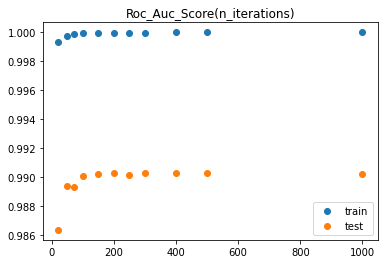

In [ ]:
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         roc_score_train, label="train")
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         roc_score_test, label="test")
plt.title("Roc_Auc_Score(n_iterations)")
plt.legend()
plt.show()

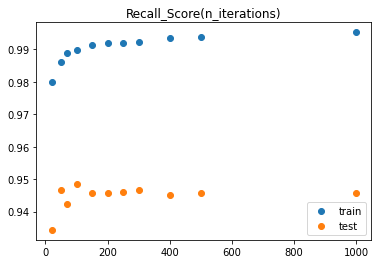

In [ ]:
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         rec_score_train, label="train")
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         rec_score_test, label="test")
plt.title("Recall_Score(n_iterations)")
plt.legend()
plt.show()

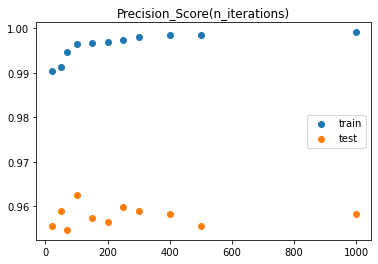

In [ ]:
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         prec_score_train, label="train")
plt.scatter([20, 50, 70, 100, 150, 200, 250, 300, 400, 500, 1000],
         prec_score_test, label="test")
plt.title("Precision_Score(n_iterations)")
plt.legend()
plt.show()

In [ ]:
ctb = CatBoostClassifier(random_seed=17, iterations=300, auto_class_weights="Balanced").fit(X_train, y_train)

In [ ]:
def do_score(X_test, y_test):
  return (roc_auc_score(y_test, ctb.predict_proba(X_test)[:, 1]),
  recall_score(y_test, ctb.predict(X_test)),
  precision_score(y_test, ctb.predict(X_test)))

In [ ]:
do_score(X_test1, y_test1)

(1.0, 1.0, 1.0)

In [ ]:
do_score(X_test2, y_test2)

(1.0, 1.0, 1.0)

In [ ]:
do_score(X_test3, y_test3)

(1.0, 1.0, 1.0)

In [ ]:
do_score(X_test4, y_test4)

(0.9974117647058823, 0.9705882352941176, 0.825)

In [ ]:
do_score(X_test5, y_test5)

(0.9993261455525606, 0.9761904761904762, 0.9534883720930233)

In [ ]:
dump(ctb, "ctb_model_punch2.joblib")

# Transfer the predictions to the initial data and draw them

### test1


In [ ]:
model = load("/content/ctb_model_punch.joblib")
model_pred = model.predict(X_test1)
pred_df = pd.DataFrame({"action_index": range(model_pred.shape[0]),
                        "model_predict": model_pred})
data_test1 = pd.merge(data_test1, pred_df, how="outer", on="action_index")

In [ ]:
fig = px.scatter(x=data_test1.index,
                 y=data_test1["R"],
                 color=data_test1["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test1.index,
                 y=data_test1["R"],
                 color=data_test1["model_predict"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

### test2

In [ ]:
model = load("/content/ctb_model_punch.joblib")
model_pred = model.predict(X_test2)
pred_df = pd.DataFrame({"action_index": range(model_pred.shape[0]),
                        "model_predict": model_pred})
data_test2 = pd.merge(data_test2, pred_df, how="outer", on="action_index")
fig = px.scatter(x=data_test2.index,
                 y=data_test2["R"],
                 color=data_test2["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test2.index,
                 y=data_test2["R"],
                 color=data_test2["model_predict"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

### test3

In [ ]:
model = load("/content/ctb_model_punch.joblib")
model_pred = model.predict(X_test3)
pred_df = pd.DataFrame({"action_index": range(model_pred.shape[0]),
                        "model_predict": model_pred})
data_test3 = pd.merge(data_test3, pred_df, how="outer", on="action_index")
fig = px.scatter(x=data_test3.index,
                 y=data_test3["R"],
                 color=data_test3["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test3.index,
                 y=data_test3["R"],
                 color=data_test3["model_predict"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

### test4

In [ ]:
model = load("/content/ctb_model_punch.joblib")
model_pred = model.predict(X_test4)
pred_df = pd.DataFrame({"action_index": range(model_pred.shape[0]),
                        "model_predict": model_pred})
data_test4 = pd.merge(data_test4, pred_df, how="outer", on="action_index")
fig = px.scatter(x=data_test4.index,
                 y=data_test4["R"],
                 color=data_test4["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test4.index,
                 y=data_test4["R"],
                 color=data_test4["model_predict"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

### test5

In [ ]:
model = load("/content/ctb_model_punch.joblib")
model_pred = model.predict(X_test5)
pred_df = pd.DataFrame({"action_index": range(model_pred.shape[0]),
                        "model_predict": model_pred})
data_test5 = pd.merge(data_test5, pred_df, how="outer", on="action_index")
fig = px.scatter(x=data_test5.index,
                 y=data_test5["R"],
                 color=data_test5["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test5.index,
                 y=data_test5["R"],
                 color=data_test5["model_predict"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

# Combined model

Based on the results of the second model, we will divide the data set into separate actions

In [ ]:
data_test5["action_index2"] = 0
action_ind = 0
for i in range(1, data_test5.shape[0]):
    if data_test5.loc[i, "model_predict"] != data_test5.loc[i - 1, "model_predict"]:
        action_ind += 1
    data_test5.loc[i, "action_index2"] = action_ind

In [ ]:
fig = px.scatter(x=data_test5.index,
                 y=data_test5["R"],
                 color=data_test5["action_index2"])\
    .update_layout(title="Залежність повного прискорення від часу (color: action_index)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

Markup data

In [ ]:
data_test5["real_action2"] = 0

jab_ind = [9, 10, 11, 22, 23, 24, 34, 35, 36, 77, 78, 79, 119, 120, 121]

uppercut_ind = [56, 57, 58, 82, 83, 84, 112, 113, 114, 123, 124, 138, 139, 140]
                
hook_ind = [47, 48, 49, 59, 60, 61, 93, 94, 95, 126, 127, 135, 136]

data_test5.loc[data_test5["action_index"].isin(jab_ind), "real_action2"] = 1
data_test5.loc[data_test5["action_index"].isin(uppercut_ind ), "real_action2"] = 2
data_test5.loc[data_test5["action_index"].isin(hook_ind), "real_action2"] = 3

Let's take only the data of punches

In [ ]:
data_test5_punch = data_test5[data_test5["model_predict"] == 1]

In [ ]:
data_test5_punch

As always, we count features and form data sets

In [ ]:
data_feature_test_acc = data_test5_punch.loc[:, ["X", "Y", "Z", "R", "action_index2"]]\
    .groupby("action_index2").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_acc = data_feature_test_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_acc = data_feature_test_acc.apply(lambda x: x.astype(float))

data_feature_test_cor = data_test5_punch.loc[:, ["Theta", "Phi", "action_index2"]]\
    .groupby("action_index2").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_cor = data_feature_test_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_cor = data_feature_test_cor.apply(lambda x: x.astype(float))

data_feature_test_acc.reset_index(inplace=True)
data_feature_test_cor.reset_index(inplace=True)
X_test = pd.merge(data_feature_test_acc, data_feature_test_cor, on="action_index2")
X_test.drop("action_index2", axis=1, inplace=True)

y_test = data_test5_punch.loc[:, ["real_action2", "action_index2"]]\
             .groupby("action_index2").aggregate(lambda x: list(set(x))[0]).real_action2

We make a prediction with a model that classifies the punchs and transfer it to the initial dataset

In [ ]:
model2 = load("/content/cat_model_full.joblib")
model_pred2 = model2.predict(X_test)
pred_df = pd.DataFrame({"action_index2": data_test5_punch["action_index2"].unique(),
                        "model_predict2": model_pred2[:, 0]})
data_test5 = pd.merge(data_test5, pred_df, how="outer", on="action_index2")

data_test5.fillna(0,inplace=True)

In [ ]:
data_test5.fillna(0,inplace=True)

In [ ]:
data_test5

We received the final result of our models.

Let's compare them with the markup.

In [ ]:
fig = px.scatter(x=data_test5.index,
                 y=data_test5["R"],
                 color=data_test5["real_action2"])\
    .update_layout(title="Залежність повного прискорення від часу (color: real_action2)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()

In [ ]:
fig = px.scatter(x=data_test5.index,
                 y=data_test5["R"],
                 color=data_test5["model_predict2"])\
    .update_layout(title="Залежність повного прискорення від часу (color: model_predict2)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

fig.show()